In [4]:
!rm -r /content/concatenated_images

In [5]:
from PIL import Image, ImageDraw,ImageFont
import os

# Output directory to save the generated images
output_dir = "digit_images/"
os.makedirs(output_dir, exist_ok=True)

# Create and save images for digits 0 to 9
for digit in range(10):
    img = Image.new("RGB", (28, 28), (255, 255, 255))  # White background
    draw = ImageDraw.Draw(img)

    # You can add the digit as text in the center with black color
    digit_font = ImageFont.load_default()
    text_width, text_height = draw.textsize(str(digit), font=digit_font)
    text_x = (28 - text_width) // 2
    text_y = (28 - text_height) // 2
    draw.text((text_x, text_y), str(digit), fill=(0, 0, 0))  # Black text

    # Save the image
    img.save(os.path.join(output_dir, f"digit_{digit}.png"))

print("Images of digits 0 to 9 with a white background and black digits have been created and saved.")


Images of digits 0 to 9 with a white background and black digits have been created and saved.


<ipython-input-5-e38bde543be8>:15: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(str(digit), font=digit_font)
<ipython-input-5-e38bde543be8>:15: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(str(digit), font=digit_font)
<ipython-input-5-e38bde543be8>:15: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(str(digit), font=digit_font)
<ipython-input-5-e38bde543be8>:15: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(str(digit), font=digit_font)
<ipython-input-5-e38bde543be8>:15: DeprecationWarning: textsize is depre

In [6]:
import os
import random
import inflect

# Output directory to save the generated images
output_dir = "concatenated_images/"
os.makedirs(output_dir, exist_ok=True)

# Output directory to save the label text file
labels_file_path = "labels.txt"

# Load the digit images (assuming they are named "digit_0.png" to "digit_9.png")
digit_images = [Image.open(f"digit_images/digit_{i}.png") for i in range(10)]

# Create an inflect engine for converting numbers to words
p = inflect.engine()

# Define the dimensions of the concatenated image
image_width = 28 * 10  # 10 digits horizontally
image_height = 28

# Create and save 100,000 concatenated images
with open(labels_file_path, "w") as labels_file:
    for i in range(10000):
        # Generate a random sequence of 10 digits as a string
        random_sequence = "".join(str(random.randint(0, 9)) for _ in range(10))

        # Convert numerical labels to word representations
        label_as_words = " ".join(p.number_to_words(digit) for digit in random_sequence)

        # Create an empty concatenated image
        concatenated_image = Image.new("RGB", (image_width, image_height), (255, 255, 255))  # White background

        # Paste each digit into the concatenated image
        for j, digit in enumerate(random_sequence):
            digit_image = digit_images[int(digit)]
            x_offset = j * 28
            concatenated_image.paste(digit_image, (x_offset, 0))

        # Generate the image filename
        image_filename = f"{random_sequence}.png"

        # Save the concatenated image with the filename representing the digit sequence
        concatenated_image.save(os.path.join(output_dir, image_filename))

        # Write the label as words to the text file
        labels_file.write(f"{image_filename}: {label_as_words}\n")

print("10,000 concatenated images have been created and labels (as words) have been saved to a text file.")


10,000 concatenated images have been created and labels (as words) have been saved to a text file.


In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
counter=0
import os
image_dir='/content/concatenated_images'
for filename in os.listdir(image_dir):
  #print(os.path.join(image_dir, filename))
  counter+=1
print(counter)

10000


In [8]:
import shutil

# Replace 'folder_to_download' with the path to the folder you want to download
folder_to_download = '/content/concatenated_images'  # Example path, replace with your folder's path
output_filename = '/content/data.zip'  # Choose a name for the ZIP file

# Create a ZIP archive of the folder
shutil.make_archive(output_filename[:-4], 'zip', folder_to_download)


'/content/data.zip'

In [9]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [10]:
BASE_DIR = '/content'
WORKING_DIR = '/content'

In [11]:
# load vgg19 model
model = VGG19()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'concatenated_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    #print(image.shape)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #print(image.shape)
    # preprocess image for vgg
    image = preprocess_input(image)
    #print(image.shape)
    # extract features
    feature = model.predict(image, verbose=0)
    #print(feature.shape)
    #print(feature)
    # get image ID
    image_id = img_name.split('.')[0]
    #print(image_id)
    # store feature
    features[image_id] = feature
    #break

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [14]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [15]:
with open(os.path.join(BASE_DIR, 'labels.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [16]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(':')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
len(mapping)

9999

In [18]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [20]:
# before preprocess of text
mapping['0000719768']


[' zero zero zero zero seven one nine seven six eight']

In [21]:
# preprocess the text
clean(mapping)

In [22]:
# after preprocess of text
mapping['0000719768']

['startseq zero zero zero zero seven one nine seven six eight endseq']

In [23]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [24]:
len(all_captions)

9999

In [25]:
all_captions[:10]

['startseq nine one five seven one two six four two eight endseq',
 'startseq four seven four six zero one four eight four five endseq',
 'startseq zero two one one seven nine four zero nine four endseq',
 'startseq six eight four six two seven eight seven nine five endseq',
 'startseq nine five seven four four six five two six nine endseq',
 'startseq one five seven five seven nine four eight one seven endseq',
 'startseq seven four seven two seven seven one one five four endseq',
 'startseq four six five four six zero seven five two zero endseq',
 'startseq six eight six one nine two three nine nine seven endseq',
 'startseq seven seven four four two seven eight nine seven zero endseq']

In [26]:
all_keys = []
for key in mapping:
    all_keys.append(key)
print(len(all_keys))
print(all_keys[:10])

9999
['9157126428', '4746014845', '0211794094', '6846278795', '9574465269', '1575794817', '7472771154', '4654607520', '6861923997', '7744278970']


In [27]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [28]:
vocab_size

13

In [29]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

12

In [30]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [31]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

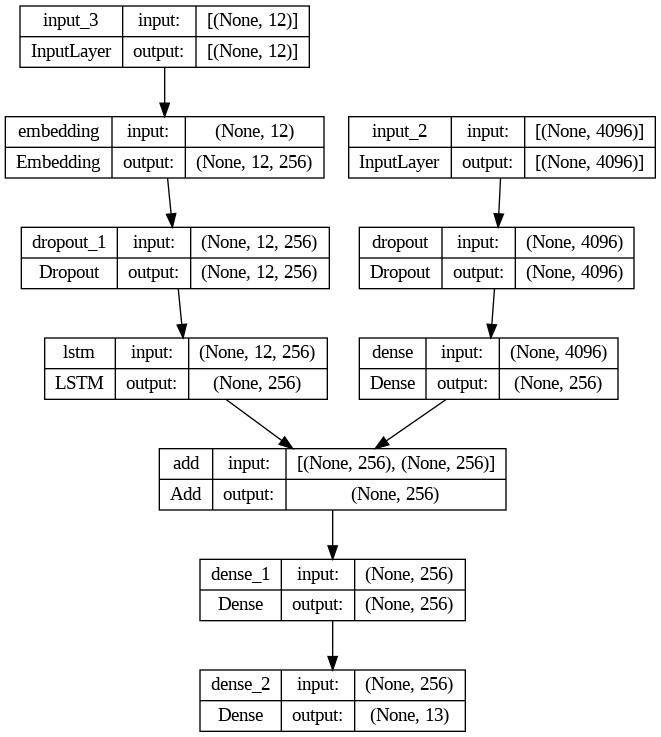

In [32]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [34]:
# train the model
epochs = 100
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

281/281 [==============================] - 19s 67ms/step - loss: 0.5528


In [35]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [37]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [38]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-1: 0.792750
BLEU-2: 0.560038


In [39]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "concatenated_images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq zero zero zero zero seven one nine seven six eight endseq
--------------------Predicted--------------------
startseq zero zero zero zero seven one nine seven six eight endseq


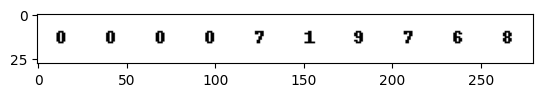

In [41]:
generate_caption("0000719768.png")

In [ ]:
# load vgg19 model
feature_model = VGG19()
# restructure the model
feature_model = Model(inputs=feature_model.inputs, outputs=feature_model.layers[-2].output)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
feat={}
def generate_caption_for_image(image_path):
    # load the image
    image_name = image_path.split('/')[-1]
    image_id=image_name.split('.')[0]
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = feature_model.predict(image, verbose=0)
    feat[image_id] = feature
    # # predict the caption
    y_pred = predict_caption(model, feat[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred,'\n')
    original_img = Image.open(image_path)
    plt.imshow(original_img)

In [ ]:
generate_caption_for_image("/content/0139467888.jpg")